Parameters Analyzed:
1. Average Closing Price: The average price at which the stock has closed over the analyzed period.
2. Maximum Closing Price: The highest recorded closing price.
3. Minimum Closing Price: The lowest recorded closing price.
4. Standard Deviation of Closing Price: Measures the volatility of the stock's closing price.
5. Average Volume: The average number of shares traded daily.
6. Maximum Volume: The highest recorded trading volume in a single day.
7. Minimum Volume: The lowest recorded trading volume in a single day.
8. Standard Deviation of Volume: Measures the volatility in trading volume.
9. Price Range : The difference between the maximum and minimum closing prices.
10. 30-Day Moving Average: A common technical indicator used to smooth out price data by creating a constantly updated average price over a 30-day period.
11. Daily Return: The daily percentage change in closing price, representing the day-to-day price momentum.
12. Volatility: Standard deviation of the daily return over a 30-day period.
13. Average Daily Volume: Measures the average trading activity.
14. Comparison of Returns vs. S&P 500: Analyzes how the individual stock returns compare to the broader market index (S&P 500).
15. Correlation Matrix of Closing Prices: Measures how the closing prices of different stocks are correlated.

In [4]:
import pyspark
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window


In [14]:
spark = SparkSession.builder.appName("Stock Data Analysis").getOrCreate()

In [7]:
companies = {
    'AAPL': '1980-12-12',
    'MSFT': '1986-03-13',
    'AMZN': '1997-05-15',
    'GOOGL': '2004-08-19',
    'META': '2012-05-18',
    'TSLA': '2010-06-29',
    'NVDA': '1999-01-22'
}

In [8]:
data = {}
for company, ipo_date in companies.items():
    data[company] = spark.read.csv(f'{company}.csv', header=True, inferSchema=True)

In [12]:
market_index = yf.download('^GSPC', start='1980-12-12', end='2024-06-01')
market_index.reset_index(inplace=True)
market_index.to_csv('SP500.csv',index=False)

[*********************100%%**********************]  1 of 1 completed


In [15]:
market_index_df = spark.read.csv("SP500.csv", header=True, inferSchema=True)

In [ ]:
window_spec = Window.orderBy('Date')
market_index_df = market_index_df.withColumn('Market_Daily_Return',(col('Close')-lag(col('Close'),1).over(window_spec))/lag(col('Close'),1).over(window_spec))

In [16]:
def statistics(df):
    statistics = df.select(
        avg('Close').alias('Average Close'),
        max('Close').alias('Max Close'),
        min('Close').alias('Min Close'),
        stddev('Close').alias('Standard Deviation Close'),
        avg('Open').alias('Average Open'),
        max('Open').alias('Max Open'),
        min('Open').alias('Min Open'),
        stddev('Open').alias('Standard Deviation Open'),
        avg('High').alias('Average High'),
        max('High').alias('Max High'),
        min('High').alias('Min High'),
        stddev('High').alias('Standard Deviation High'),
        avg('Low').alias('Average Low'),
        max('Low').alias('Max Low'),
        min('Low').alias('Min Low'),
        stddev('Low').alias('Standard Deviation Low'),
        avg('Volume').alias('Average Volume'),
        max('Volume').alias('Max Volume'),
        min('Volume').alias('Min Volume'),
        stddev('Volume').alias('Standard Deviation Volume')
    )
    return statistics

In [47]:
def calculate_price_range(df):
    price_range = df.select((max('Close') - min('Close')).alias('Price_Range')).collect()[0]['Price_Range']
    return price_range

In [48]:

for company, df in data.items():
    price_range_value = calculate_price_range(df)
    print(f"{company} : Price Range - {price_range_value}")


AAPL : Price Range - 198.06089361011982
MSFT : Price Range - 430.42971101403236
AMZN : Price Range - 189.4302079975605
GOOGL : Price Range - 175.34725308418274
META : Price Range - 509.6100273132324
TSLA : Price Range - 408.916668176651
NVDA : Price Range - 114.79088194668293


In [17]:
def creating_features(df, window=30):
    window_spec = Window.orderBy('Date').rowsBetween(-window,0)
    df = df.withColumn('Moving Average', avg('Close').over(window_spec))
    df = df.withColumn('Daily Return',(col('Close')-lag(col('Close'),1).over(Window.orderBy('Date')))/lag(col('Close'),1).over(Window.orderBy('Date')))
    df = df.withColumn('Volatility',stddev('Daily Return').over(window_spec))
    return df

AAPL : 
+-----------------+------------------+-------------------+------------------------+-----------------+------------------+--------------------+-----------------------+-----------------+-----------------+--------------------+-----------------------+-----------------+-------+-------------------+----------------------+--------------------+----------+----------+-------------------------+
|    Average Close|         Max Close|          Min Close|Standard Deviation Close|     Average Open|          Max Open|            Min Open|Standard Deviation Open|     Average High|         Max High|            Min High|Standard Deviation High|      Average Low|Max Low|            Min Low|Standard Deviation Low|      Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+-----------------+------------------+-------------------+------------------------+-----------------+------------------+--------------------+-----------------------+-----------------+-----------------+--------------------+

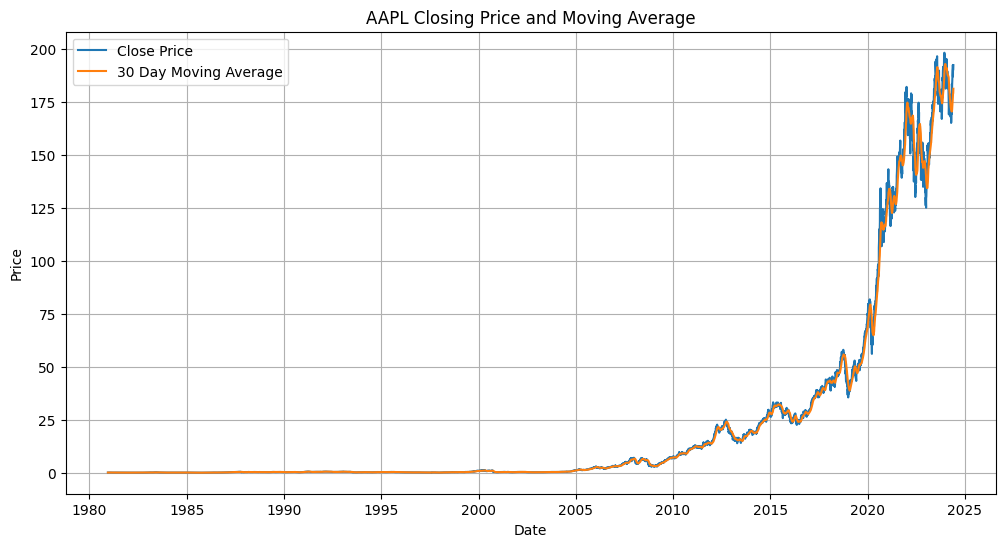

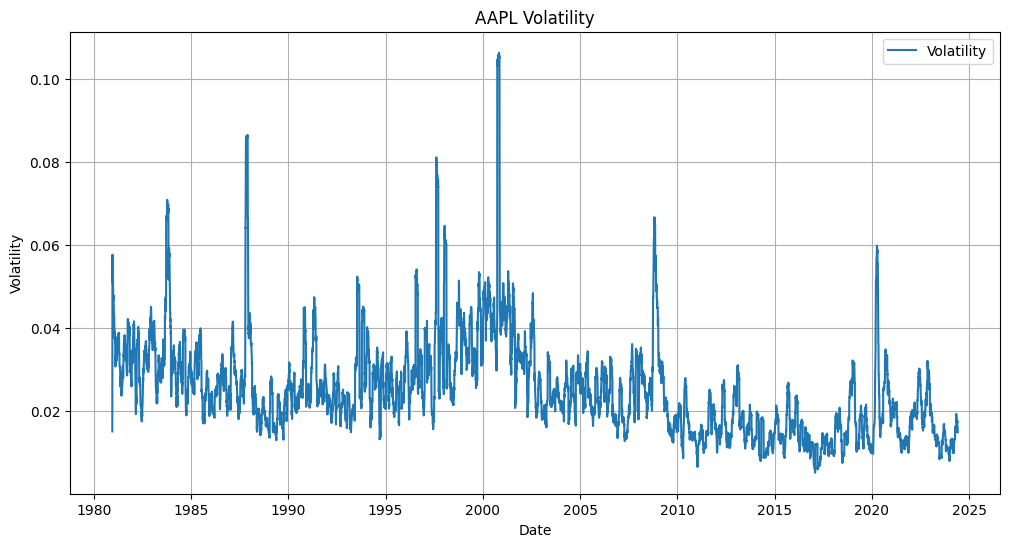

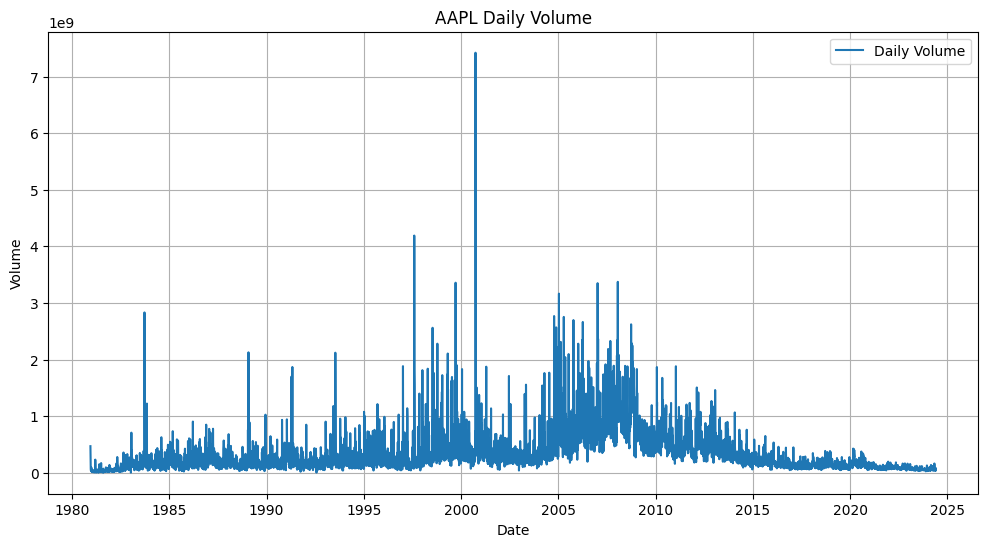

MSFT : 
+------------------+-----------------+-------------------+------------------------+----------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-------------------+-----------------------+-----------------+-----------------+-------------------+----------------------+-------------------+----------+----------+-------------------------+
|     Average Close|        Max Close|          Min Close|Standard Deviation Close|    Average Open|         Max Open|           Min Open|Standard Deviation Open|     Average High|         Max High|           Min High|Standard Deviation High|      Average Low|          Max Low|            Min Low|Standard Deviation Low|     Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+------------------+-----------------+-------------------+------------------------+----------------+-----------------+-------------------+-----------------------+-----------------+-----------------+--------------

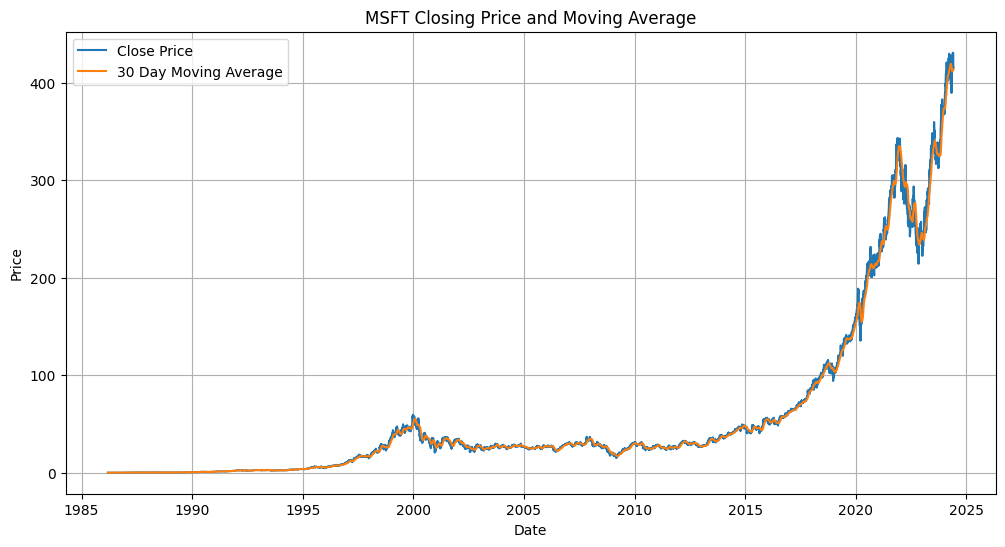

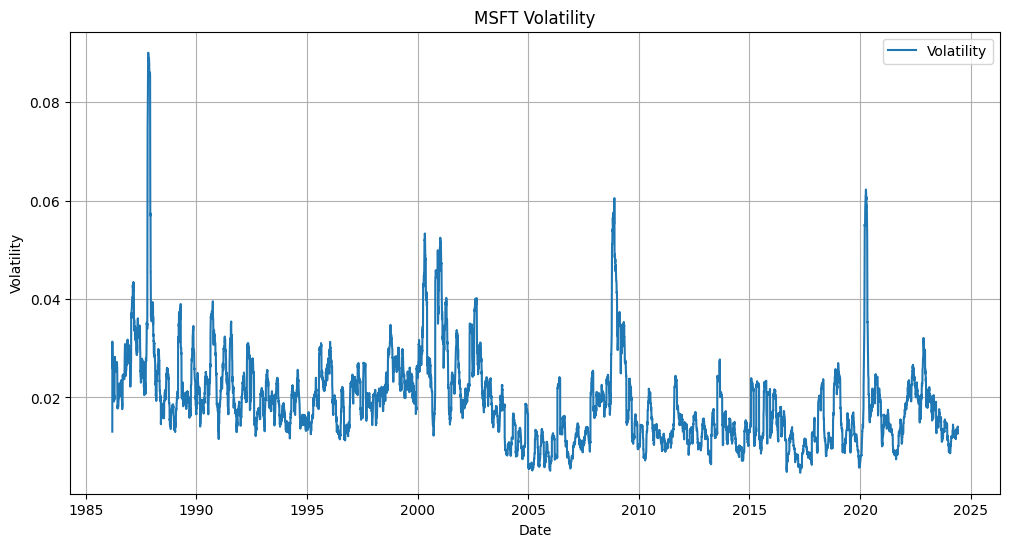

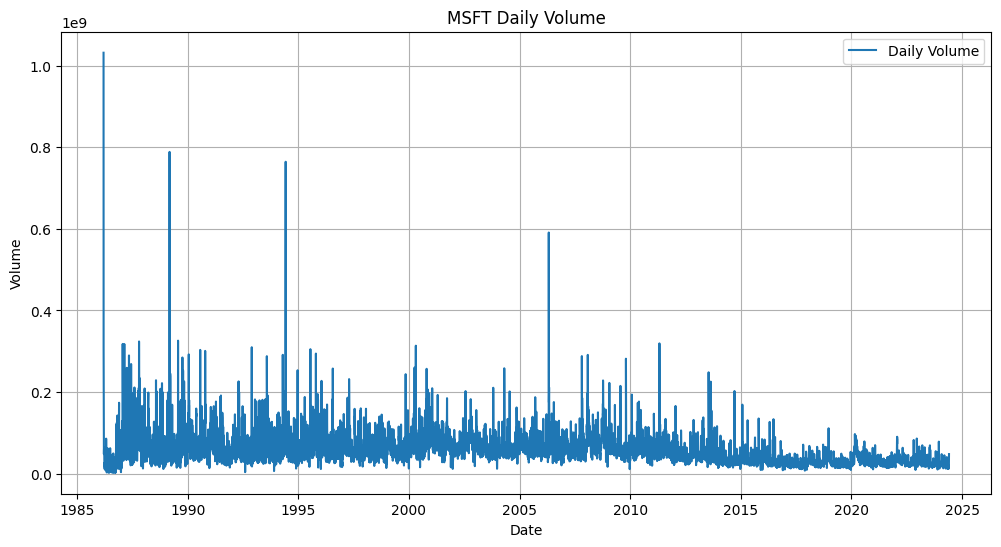

AMZN : 
+-----------------+---------+------------------+------------------------+-----------------+------------------+---------------+-----------------------+-----------------+-----------------+-------------------+-----------------------+-----------------+------------------+-------------------+----------------------+-------------------+----------+----------+-------------------------+
|    Average Close|Max Close|         Min Close|Standard Deviation Close|     Average Open|          Max Open|       Min Open|Standard Deviation Open|     Average High|         Max High|           Min High|Standard Deviation High|      Average Low|           Max Low|            Min Low|Standard Deviation Low|     Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+-----------------+---------+------------------+------------------------+-----------------+------------------+---------------+-----------------------+-----------------+-----------------+-------------------+-----------------------+----

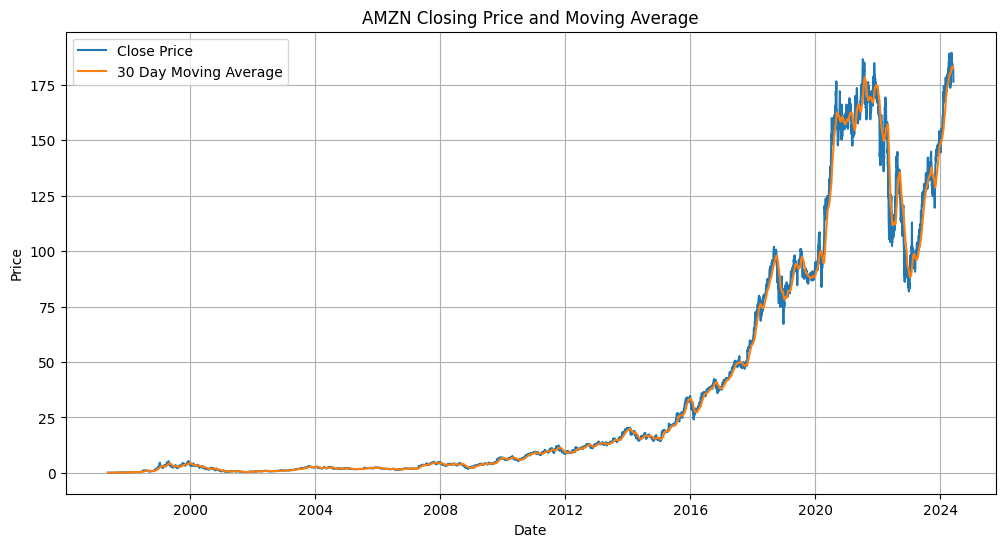

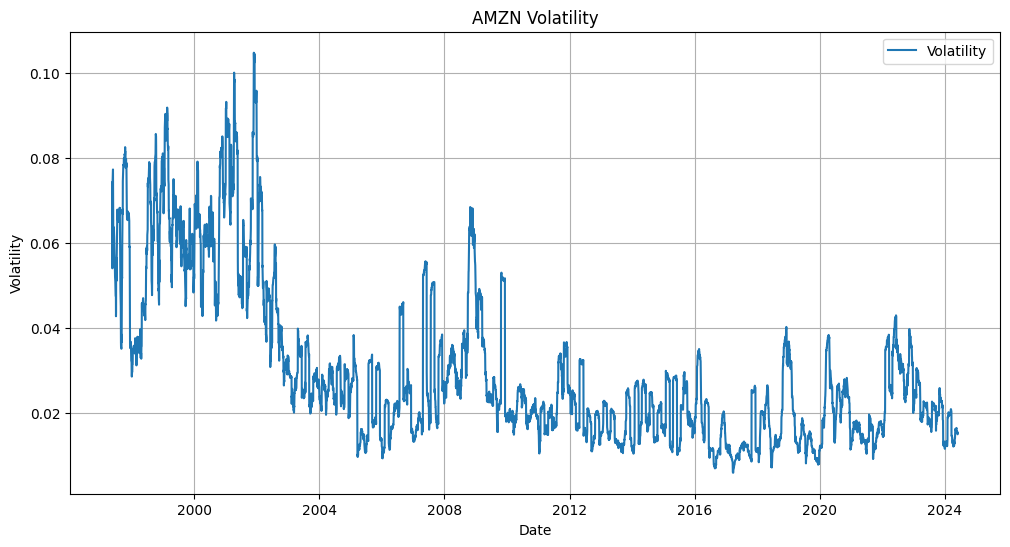

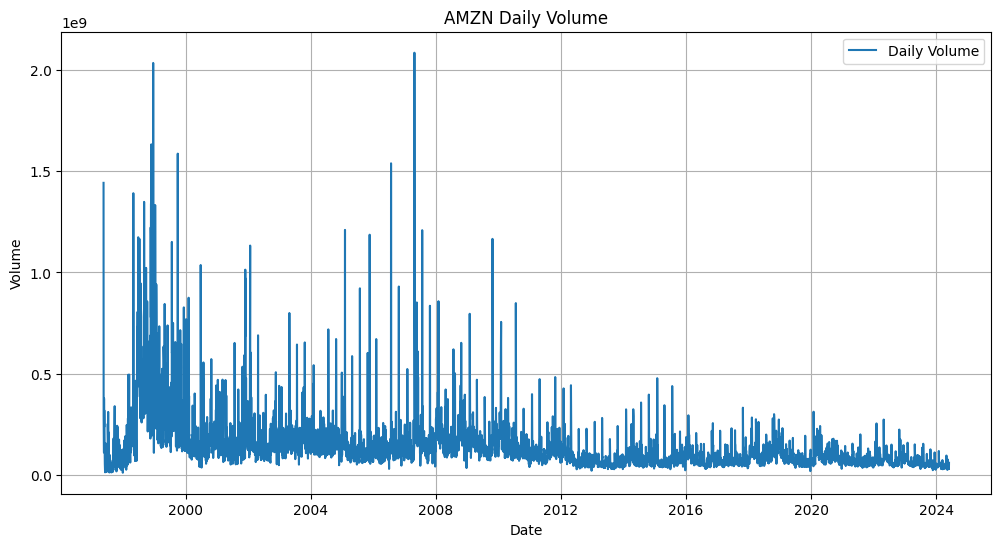

GOOGL : 
+-----------------+------------------+------------------+------------------------+-----------------+------------------+-----------------+-----------------------+-----------------+------------------+-----------------+-----------------------+-----------------+-----------------+------------------+----------------------+--------------------+----------+----------+-------------------------+
|    Average Close|         Max Close|         Min Close|Standard Deviation Close|     Average Open|          Max Open|         Min Open|Standard Deviation Open|     Average High|          Max High|         Min High|Standard Deviation High|      Average Low|          Max Low|           Min Low|Standard Deviation Low|      Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+-----------------+------------------+------------------+------------------------+-----------------+------------------+-----------------+-----------------------+-----------------+------------------+-----------------

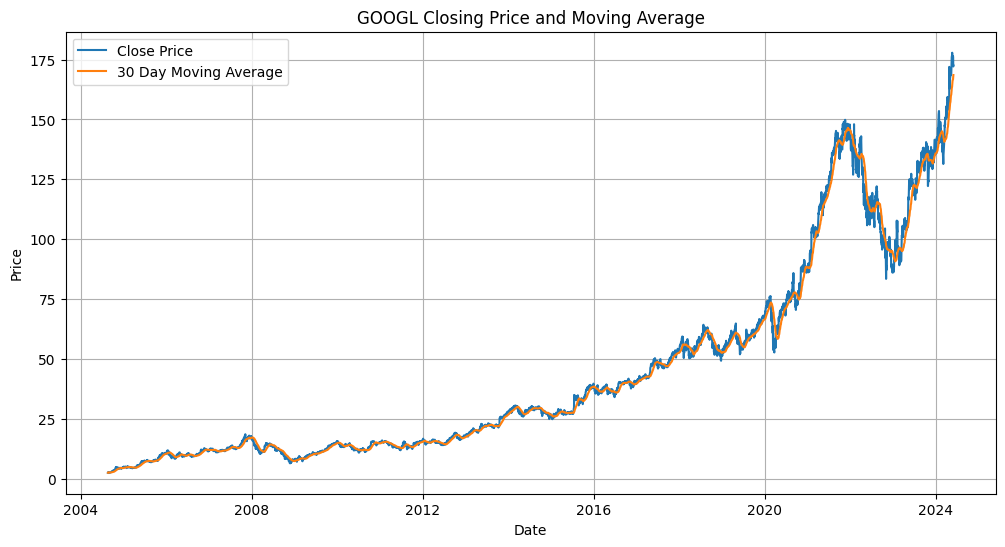

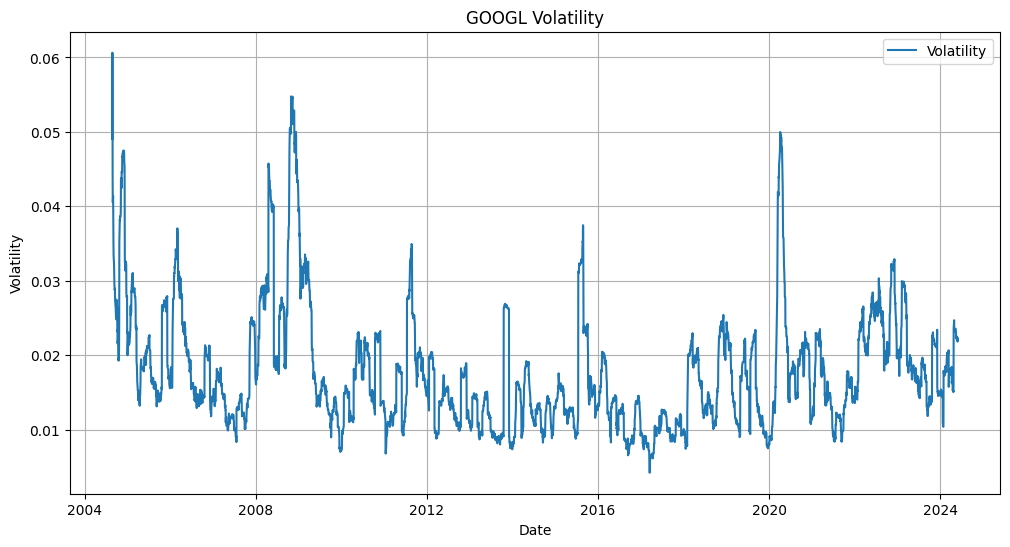

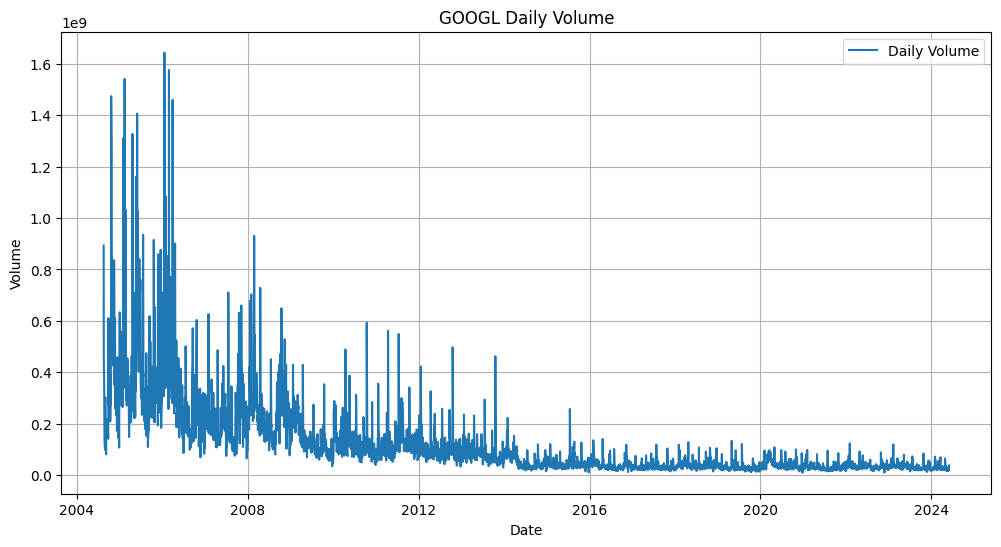

META : 
+-----------------+-----------------+------------------+------------------------+------------------+----------------+------------------+-----------------------+------------------+----------------+------------------+-----------------------+------------------+-----------------+------------------+----------------------+--------------------+----------+----------+-------------------------+
|    Average Close|        Max Close|         Min Close|Standard Deviation Close|      Average Open|        Max Open|          Min Open|Standard Deviation Open|      Average High|        Max High|          Min High|Standard Deviation High|       Average Low|          Max Low|           Min Low|Standard Deviation Low|      Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+-----------------+-----------------+------------------+------------------------+------------------+----------------+------------------+-----------------------+------------------+----------------+------------------+-

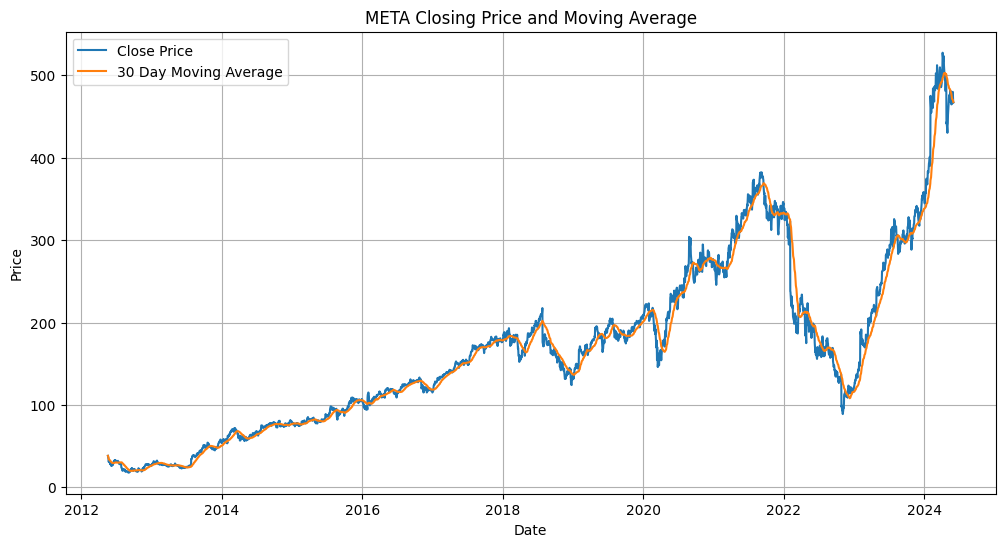

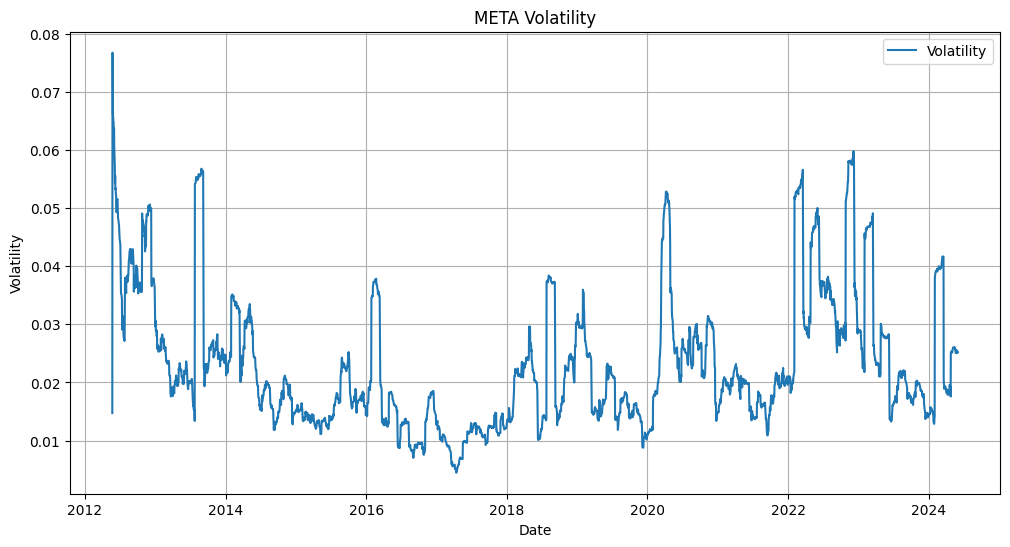

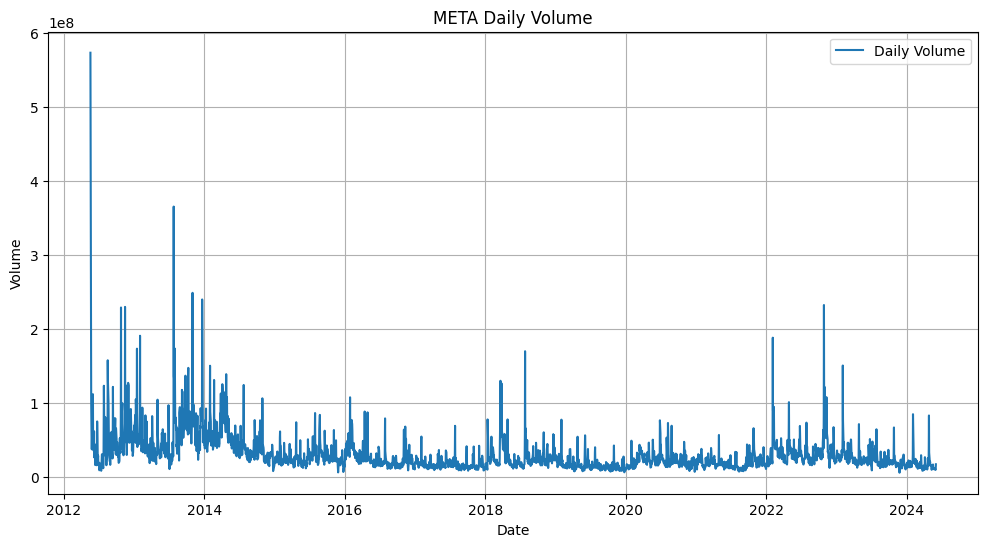

TSLA : 
+-----------------+-----------------+-----------------+------------------------+-----------------+-----------------+------------------+-----------------------+-----------------+-----------------+-----------------+-----------------------+-----------------+-----------------+------------------+----------------------+-------------------+----------+----------+-------------------------+
|    Average Close|        Max Close|        Min Close|Standard Deviation Close|     Average Open|         Max Open|          Min Open|Standard Deviation Open|     Average High|         Max High|         Min High|Standard Deviation High|      Average Low|          Max Low|           Min Low|Standard Deviation Low|     Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+-----------------+-----------------+-----------------+------------------------+-----------------+-----------------+------------------+-----------------------+-----------------+-----------------+-----------------+-----------

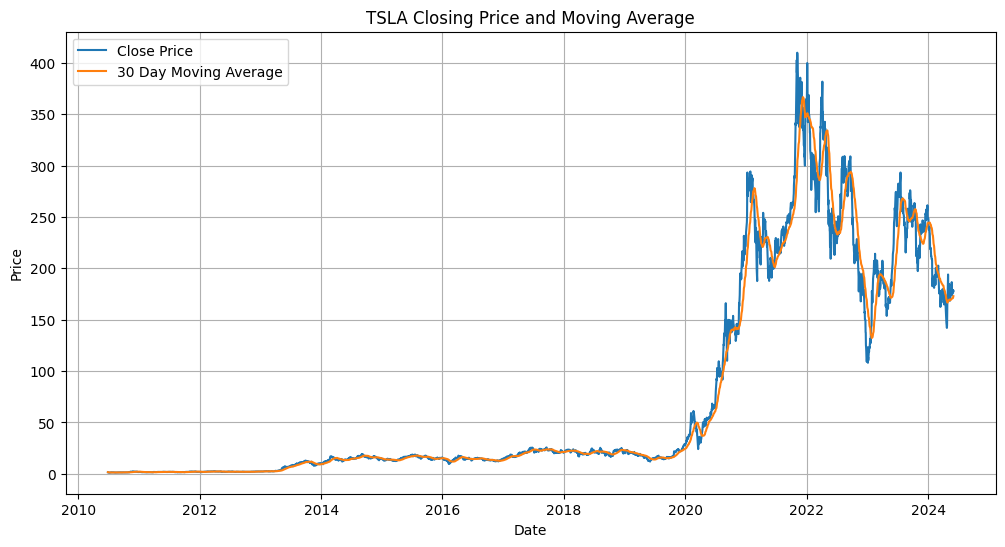

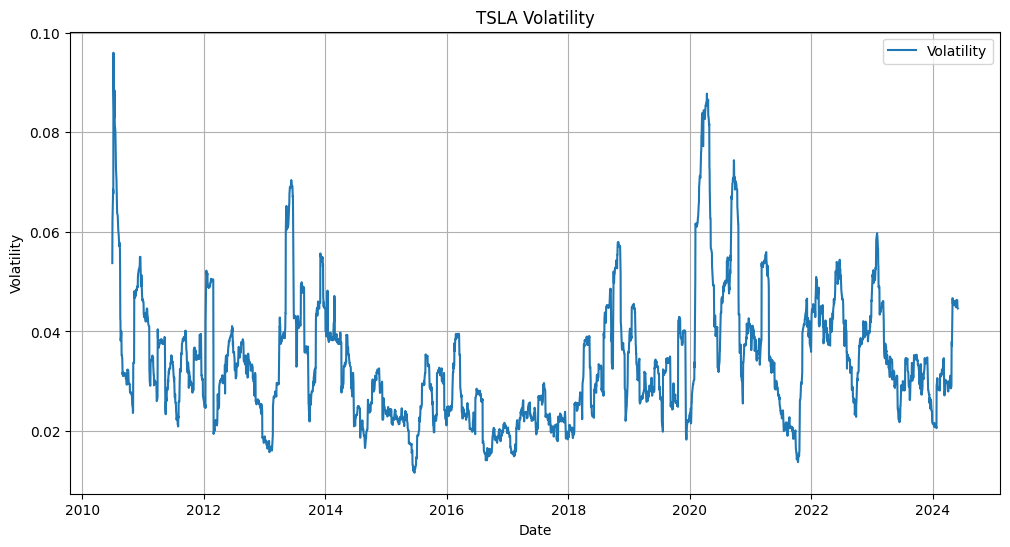

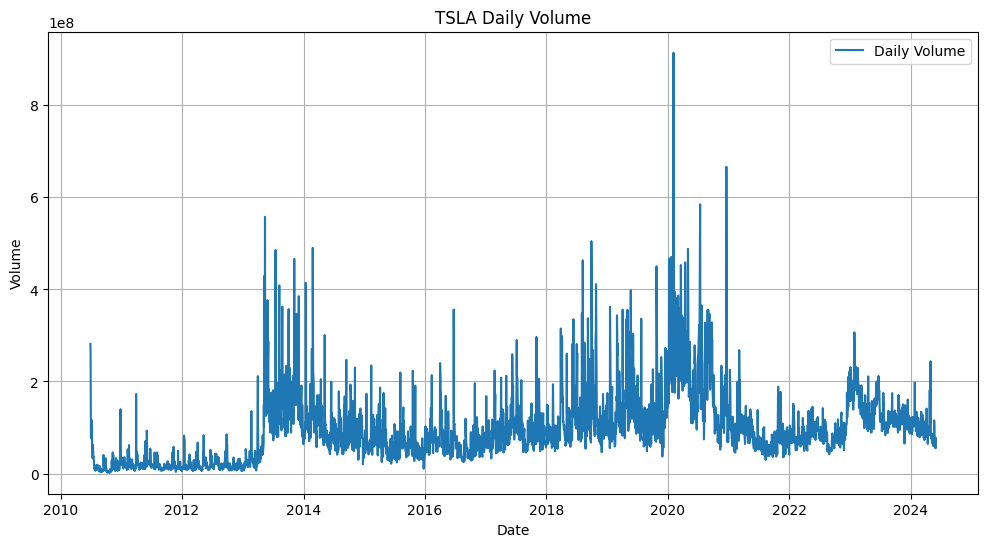

NVDA : 
+-----------------+------------------+-------------------+------------------------+----------------+-----------------+-------------------+-----------------------+----------------+------------------+-------------------+-----------------------+-----------------+-----------------+-------------------+----------------------+-------------------+----------+----------+-------------------------+
|    Average Close|         Max Close|          Min Close|Standard Deviation Close|    Average Open|         Max Open|           Min Open|Standard Deviation Open|    Average High|          Max High|           Min High|Standard Deviation High|      Average Low|          Max Low|            Min Low|Standard Deviation Low|     Average Volume|Max Volume|Min Volume|Standard Deviation Volume|
+-----------------+------------------+-------------------+------------------------+----------------+-----------------+-------------------+-----------------------+----------------+------------------+--------------

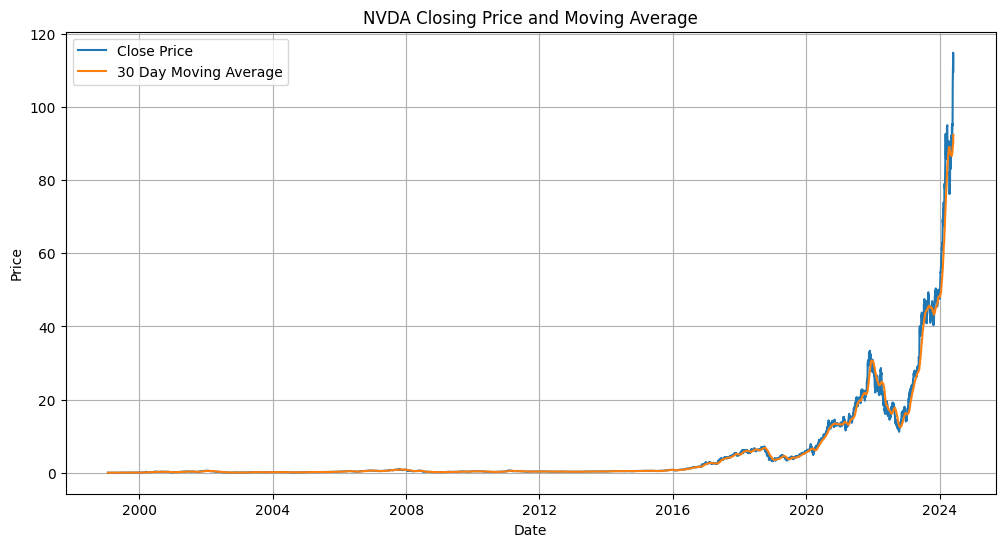

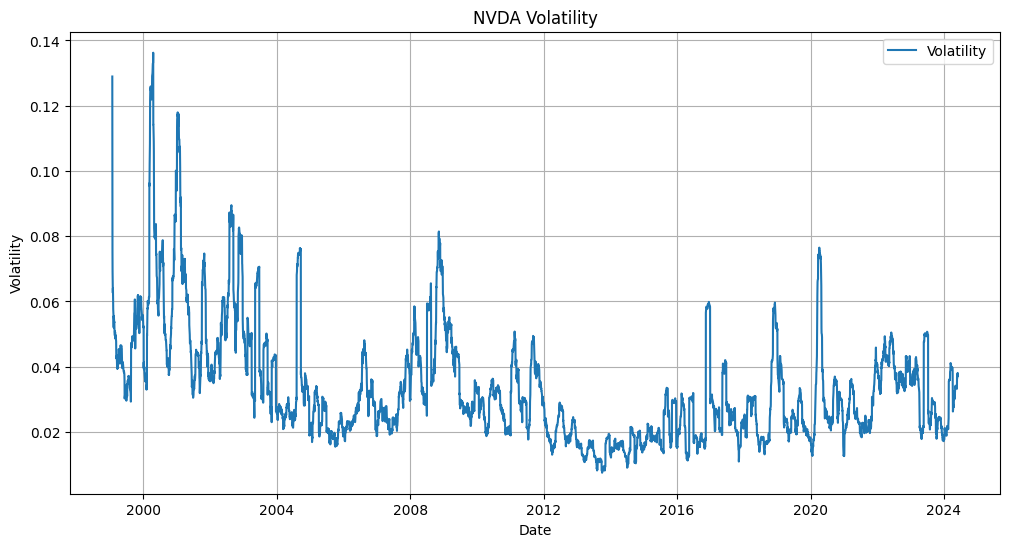

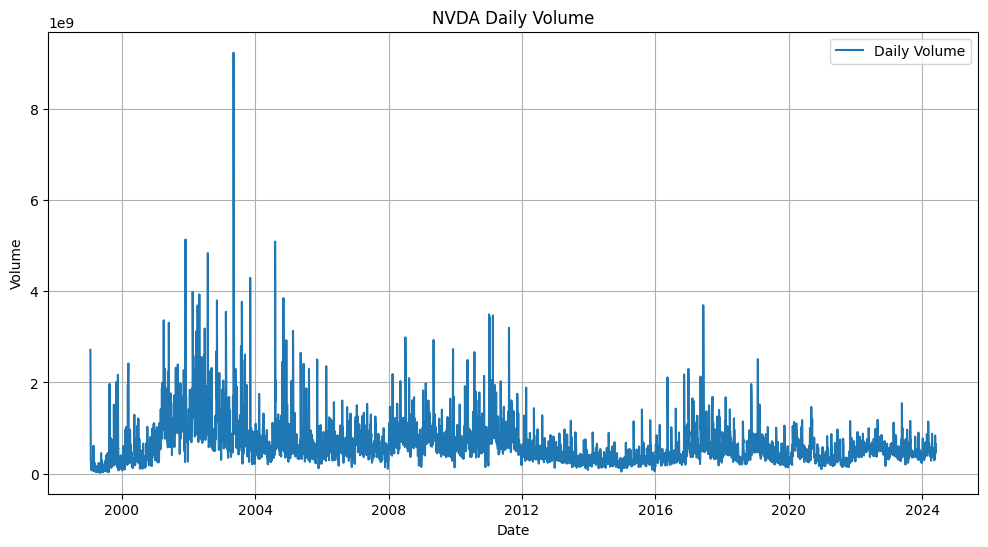

In [19]:
for company, df in data.items():
    print(f"{company} : ")
    stats = statistics(df)
    stats.show()
    df = creating_features(df)
    data[company] = df
    pdf = df.select('Date', 'Close', 'Moving Average', 'Daily Return', 'Volatility', 'Volume').toPandas()
    pdf['Date'] = pd.to_datetime(pdf['Date'])
    plt.figure(figsize=(12, 6))
    plt.plot(pdf['Date'], pdf['Close'], label='Close Price')
    plt.plot(pdf['Date'], pdf['Moving Average'], label='30 Day Moving Average')
    plt.title(f"{company} Closing Price and Moving Average")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(pdf['Date'], pdf['Volatility'], label='Volatility')
    plt.title(f"{company} Volatility")
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(pdf['Date'], pdf['Volume'], label='Daily Volume')
    plt.title(f'{company} Daily Volume')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
close_prices = {}

In [22]:
for company, df in data.items():
    close_prices[company] = df.select('Date','Close').withColumnRenamed('Close',f'{company}_close')

In [23]:
total_df = close_prices.popitem()[1]
for company, df in close_prices.items():
    total_df = total_df.join(df, on='Date')

In [24]:
total_df = total_df.toPandas()
total_df['Date'] = pd.to_datetime(total_df['Date'])
total_df.set_index('Date',inplace=True)

In [25]:
correlation_matrix = total_df.corr()

In [26]:
print("Correlation Matrix of the company closing prices - ")
print(correlation_matrix)

Correlation Matrix of the company closing prices - 
             NVDA_close  AAPL_close  MSFT_close  AMZN_close  GOOGL_close  \
NVDA_close     1.000000    0.812951    0.866433    0.702682     0.830641   
AAPL_close     0.812951    1.000000    0.981427    0.884784     0.964041   
MSFT_close     0.866433    0.981427    1.000000    0.918337     0.980912   
AMZN_close     0.702682    0.884784    0.918337    1.000000     0.925175   
GOOGL_close    0.830641    0.964041    0.980912    0.925175     1.000000   
META_close     0.820465    0.815062    0.885374    0.915558     0.896581   
TSLA_close     0.664564    0.934718    0.889645    0.823743     0.906806   

             META_close  TSLA_close  
NVDA_close     0.820465    0.664564  
AAPL_close     0.815062    0.934718  
MSFT_close     0.885374    0.889645  
AMZN_close     0.915558    0.823743  
GOOGL_close    0.896581    0.906806  
META_close     1.000000    0.703569  
TSLA_close     0.703569    1.000000  


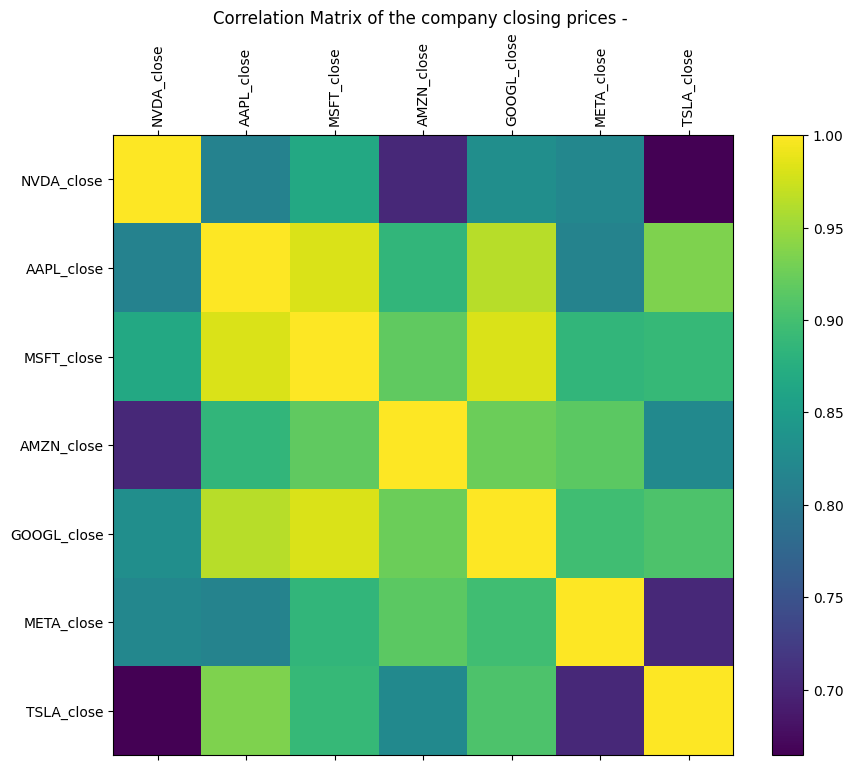

In [27]:
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.title("Correlation Matrix of the company closing prices - ")
plt.show()

In [34]:
window_spec = Window.orderBy('Date')
market_index_df = market_index_df.withColumn('Market_Daily_Return',(col('Close') - lag(col('Close'), 1).over(window_spec)) / lag(col('Close'), 1).over(window_spec))

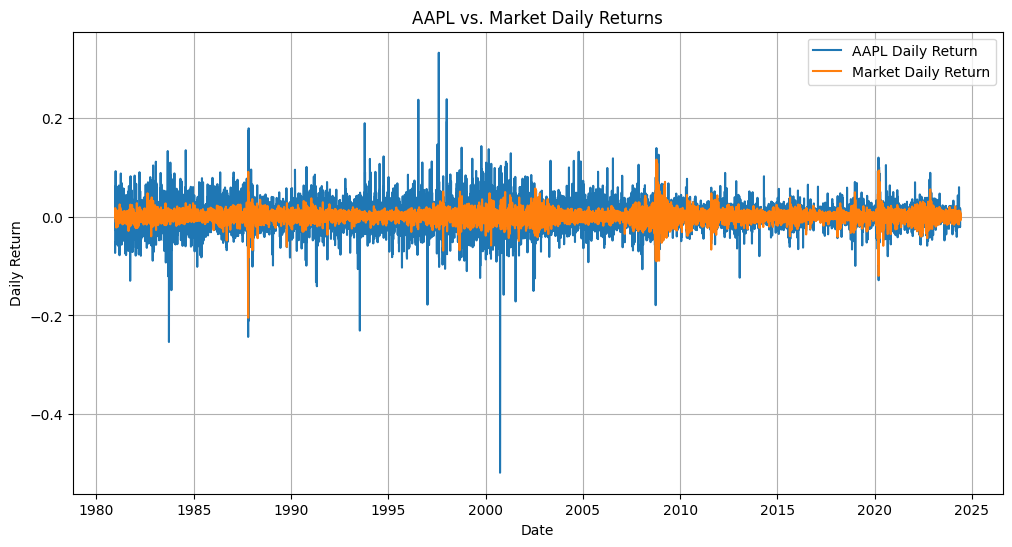

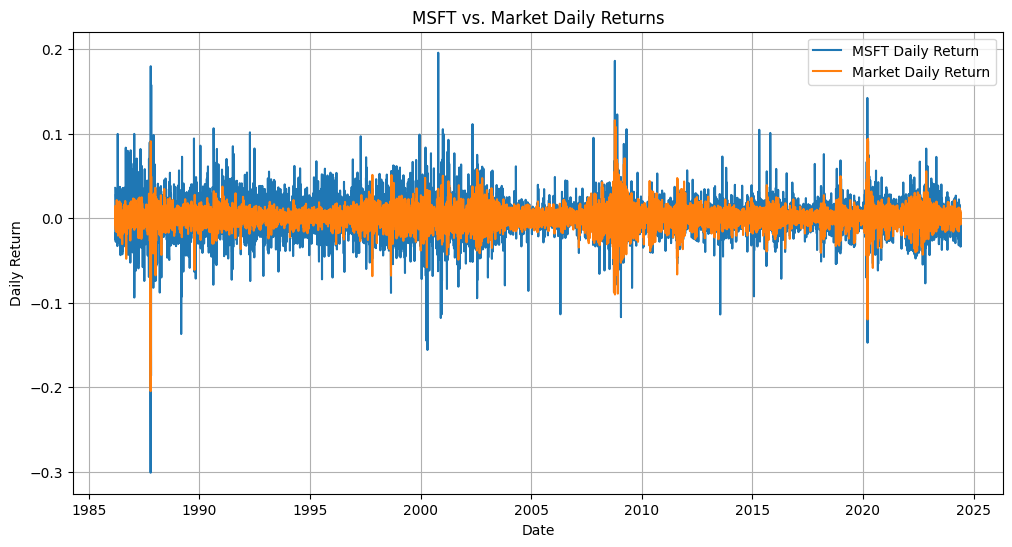

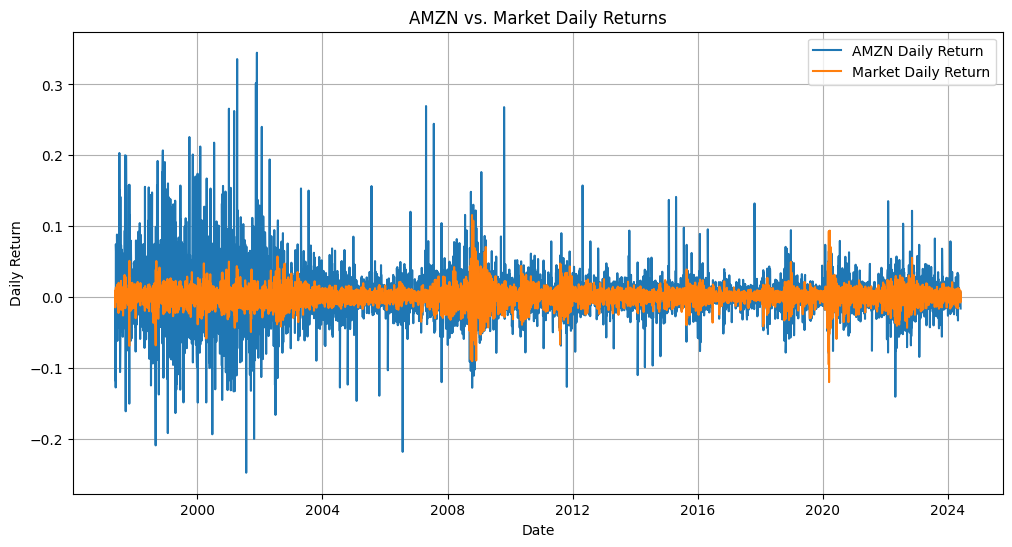

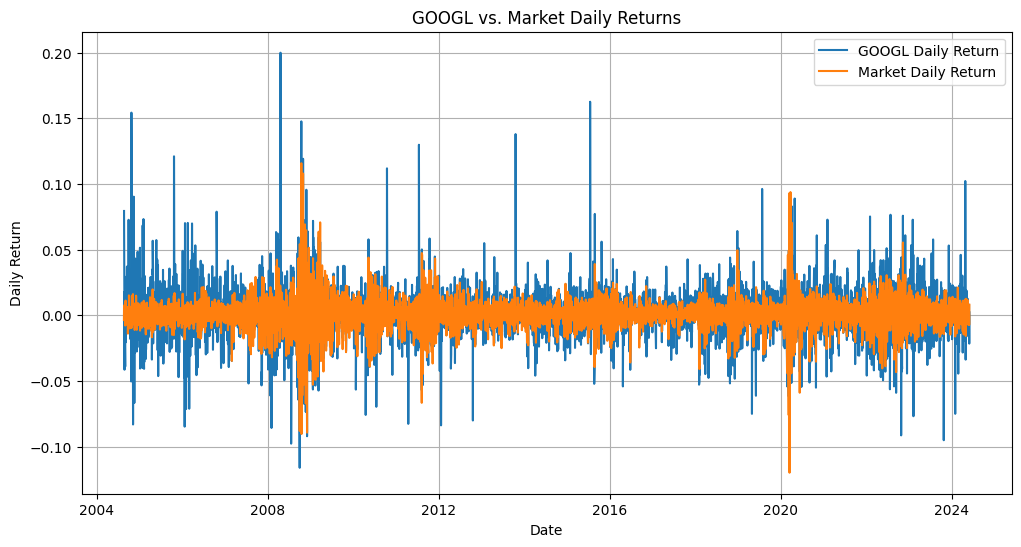

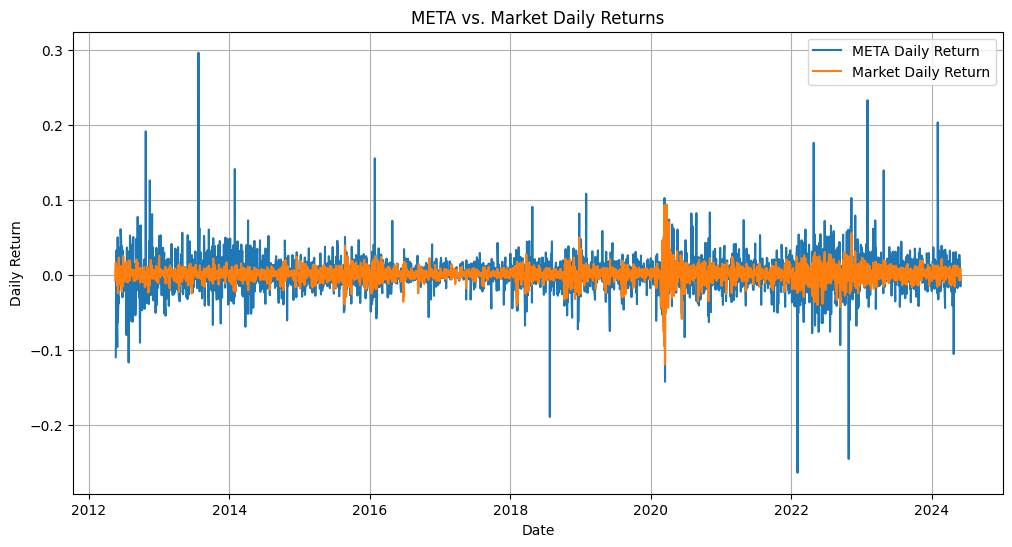

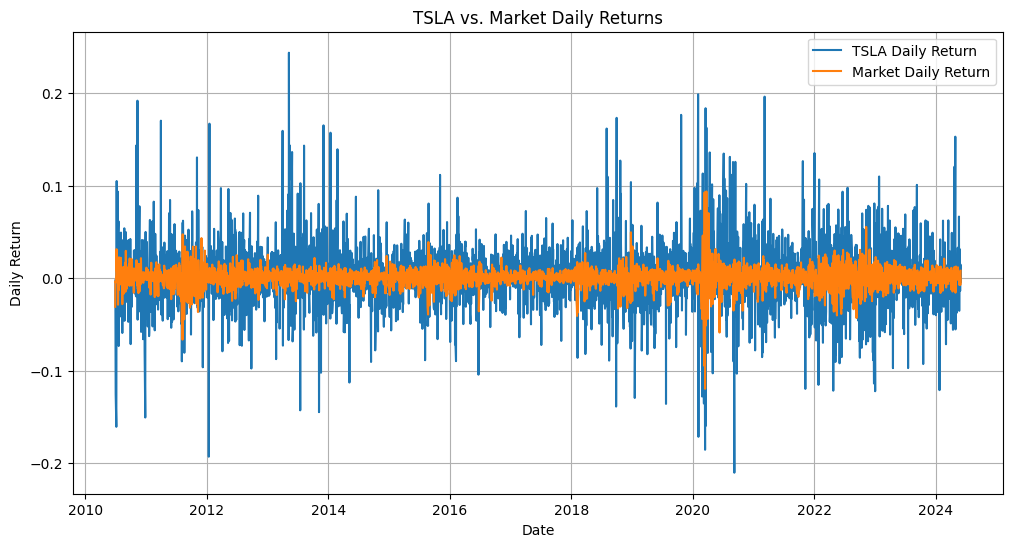

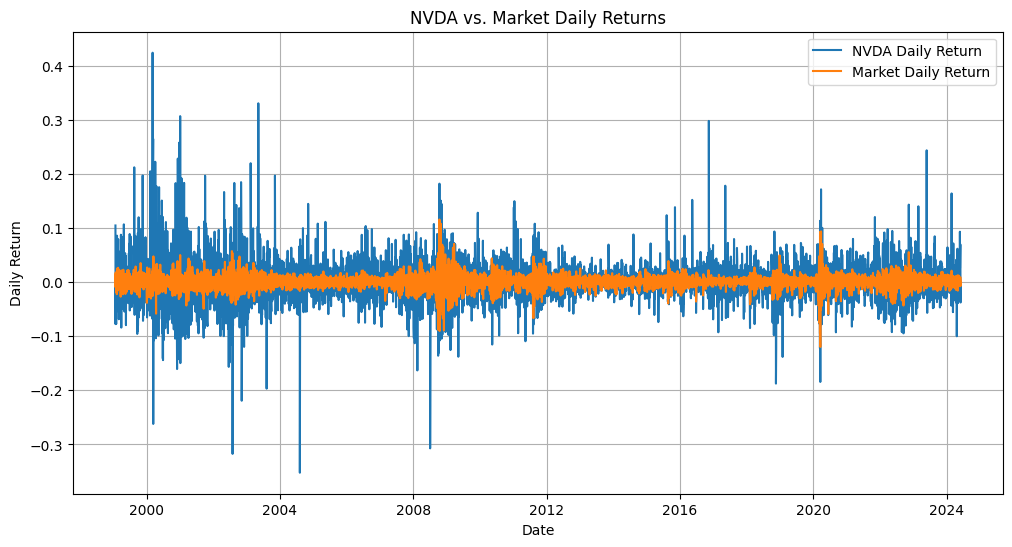

In [35]:
for company, df in data.items():
    df = df.withColumn('Daily Return',(col('Close') - lag(col('Close'), 1).over(window_spec)) / lag(col('Close'), 1).over(window_spec))
    company_df = df.select('Date', 'Close', 'Daily Return')
    market_df = market_index_df.select(col('Date').alias('Market_Date'), col('Close').alias('Market_Close'), col('Market_Daily_Return'))
    joined_df = company_df.join(market_df, company_df['Date'] == market_df['Market_Date']).drop('Market_Date')
    joined_pdf = joined_df.toPandas()
    joined_pdf['Date'] = pd.to_datetime(joined_pdf['Date'])
    plt.figure(figsize=(12, 6))
    plt.plot(joined_pdf['Date'], joined_pdf['Daily Return'], label=f'{company} Daily Return')
    plt.plot(joined_pdf['Date'], joined_pdf['Market_Daily_Return'], label='Market Daily Return')
    plt.title(f'{company} vs. Market Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()